## Comparing random sampling of text corpus to original after LDA

In [19]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import sklearn dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data
original_labels = newsgroups.target

# convert to bag of words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(documents)
vocab = np.array(vectorizer.get_feature_names_out())

In [20]:
def resample_documents(word_counts, depth=100, return_labels=False):
    new_docs = []
    new_labels = []

    for doc_idx in range(word_counts.shape[0]):
        word_indices = word_counts[doc_idx].nonzero()[1]  # nonzero words in the doc

        if len(word_indices) == 0:  # skip empty documents
            new_docs.append("")
            if return_labels:
                new_labels.append(original_labels[doc_idx])
            continue

        word_frequencies = word_counts[doc_idx].toarray().flatten()[word_indices]
        probabilities = word_frequencies / word_frequencies.sum()

        sampled_indices = np.random.choice(word_indices, size=depth, p=probabilities)
        new_doc = ' '.join(vocab[sampled_indices])

        new_docs.append(new_doc)
        if return_labels:
            new_labels.append(original_labels[doc_idx])

    if return_labels:
        return new_docs, new_labels
    return new_docs

In [21]:
def resample_documents_random_depth(word_counts, return_labels=False):
    new_docs = []
    new_labels = []

    possible_depths = [25, 50, 100, 200]

    for doc_idx in range(word_counts.shape[0]):
        word_indices = word_counts[doc_idx].nonzero()[1]  # nonzero words in the doc

        if len(word_indices) == 0:  # skip empty documents
            new_docs.append("")
            if return_labels:
                new_labels.append(original_labels[doc_idx])
            continue

        word_frequencies = word_counts[doc_idx].toarray().flatten()[word_indices]
        probabilities = word_frequencies / word_frequencies.sum()

        depth = np.random.choice(possible_depths)
        sampled_indices = np.random.choice(word_indices, size=depth, p=probabilities, replace=True)
        new_doc = ' '.join(vocab[sampled_indices])

        new_docs.append(new_doc)
        if return_labels:
            new_labels.append(original_labels[doc_idx])

    if return_labels:
        return new_docs, new_labels
    return new_docs

In [22]:
# run LDA on the original dataset
num_topics = 6
lda_original = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_original.fit(word_counts)
original_topic_distributions = lda_original.components_ / lda_original.components_.sum(axis=1, keepdims=True)

# display the top words for each topic
vocab = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda_original.components_):
    top_words = vocab[np.argsort(topic)[-10:]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: data mail just does know key new like use edu
Topic 1: 1t 34u 1d9 145 pl a86 b8f g9v max ax
Topic 2: 15 20 50 10 program output entry db file 00
Topic 3: car going said time think know like just don people
Topic 4: motif program server windows problem file using edu use window
Topic 5: know jesus like say does just don think god people



 Running LDA at sampling depth 50...

 Top words per topic (Depth=50):
Topic 0: did don game time new know does think like just
Topic 1: answer problems hello work space does like use people ax
Topic 2: got believe ve case time like use don just good
Topic 3: use got new com people like just think test drive
Topic 4: help using hi like don just windows does know thanks
Topic 5: just believe time know think like say don god people


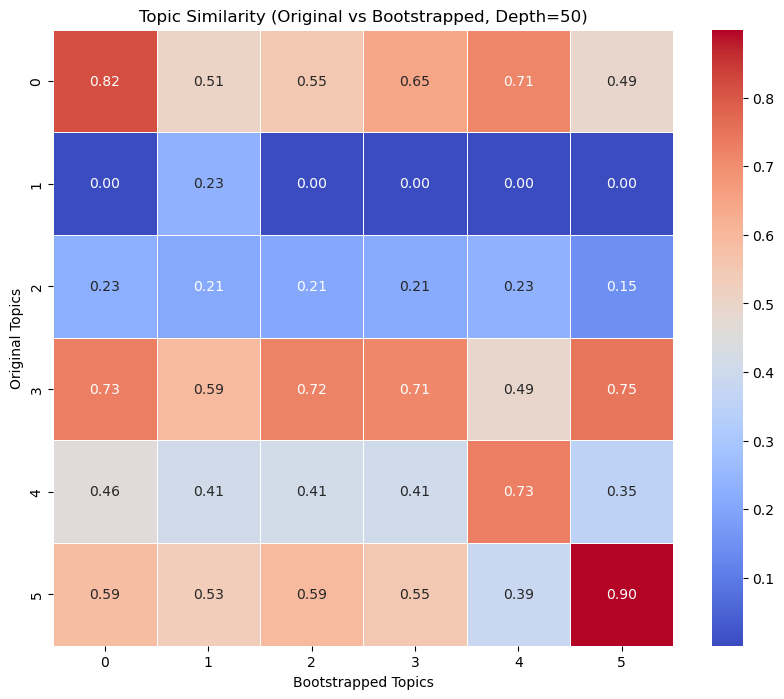

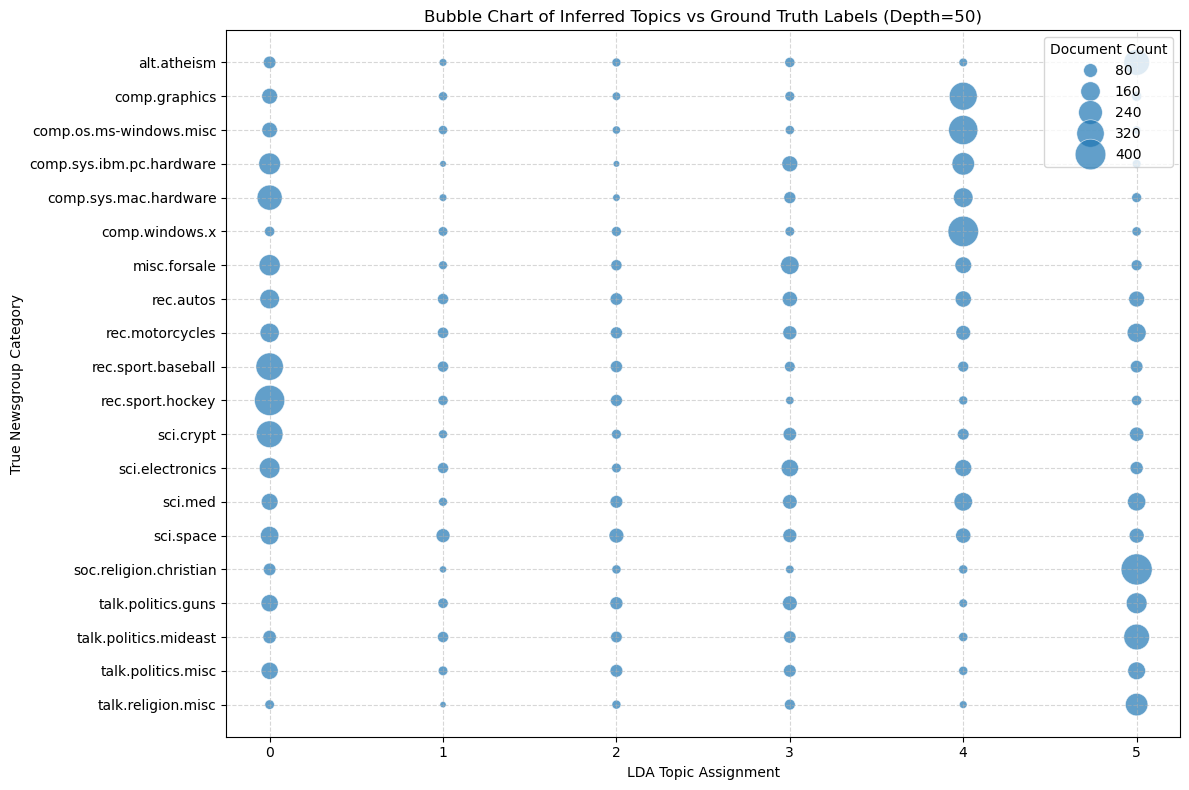


 Running LDA at sampling depth 100...

 Top words per topic (Depth=100):
Topic 0: games drive don edu does just like think game new
Topic 1: way article just like problems does use people ax space
Topic 2: right year list time like don use just ve good
Topic 3: car drive chip like right people test think key just
Topic 4: don problem using use just like windows does know thanks
Topic 5: said time just like know say think don god people


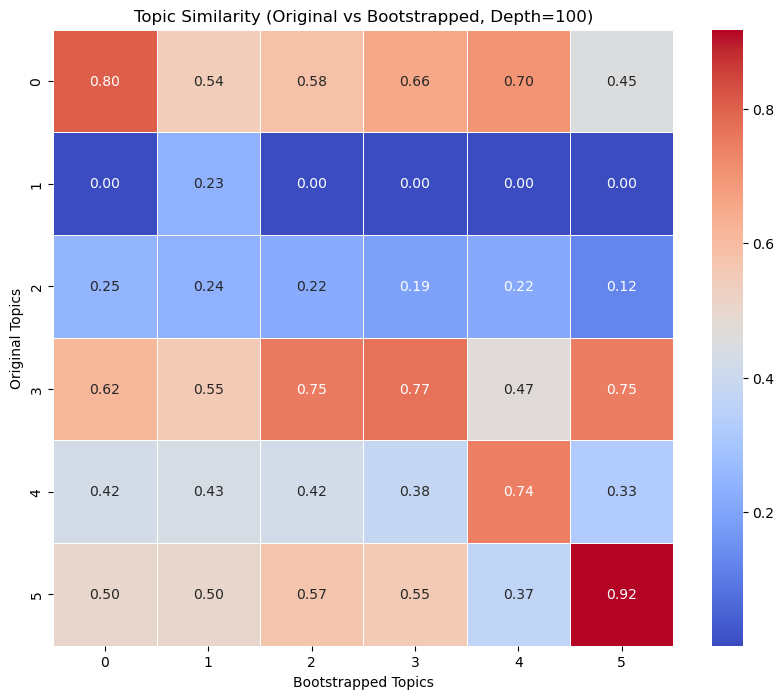

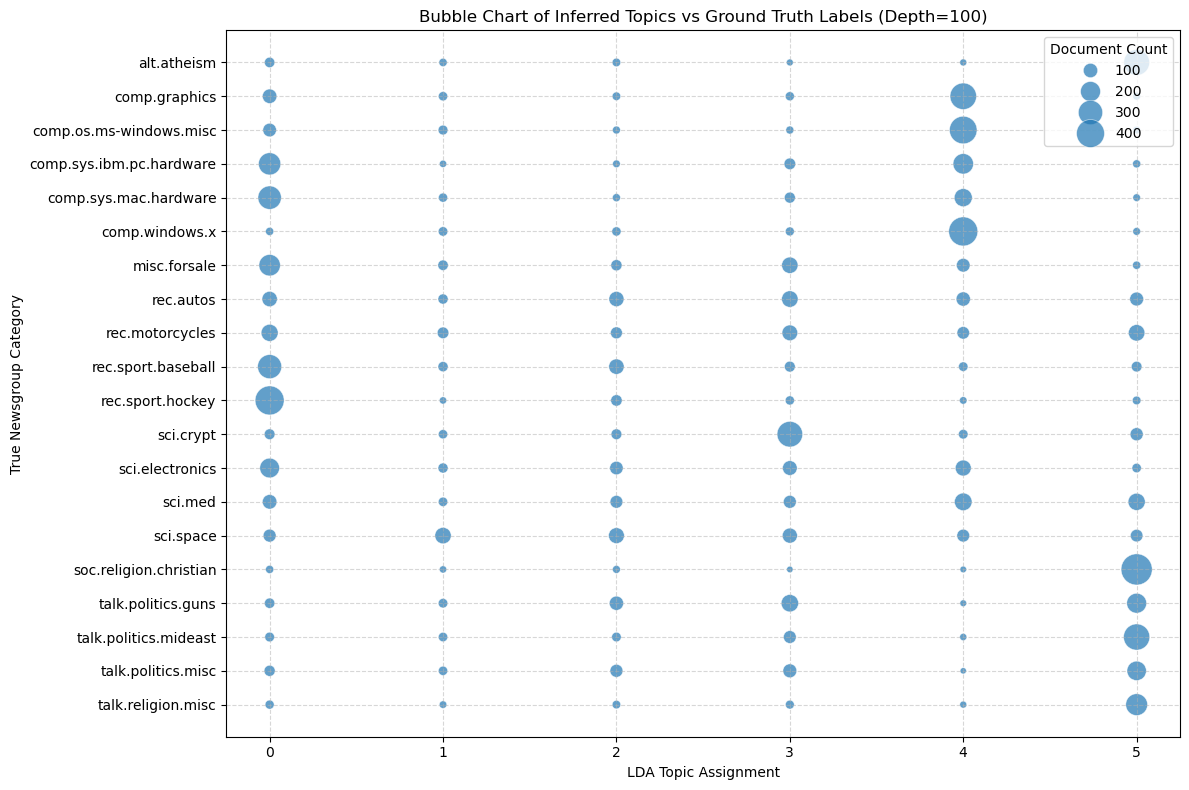


 Running LDA at sampling depth 200...

 Top words per topic (Depth=200):
Topic 0: year don does team edu new just like think game
Topic 1: work hello problems way file does space use like ax
Topic 2: know people list time use ve like don good just
Topic 3: don new com test like drive people think just car
Topic 4: help hi just problem use like windows does know thanks
Topic 5: believe time just like know think don say god people


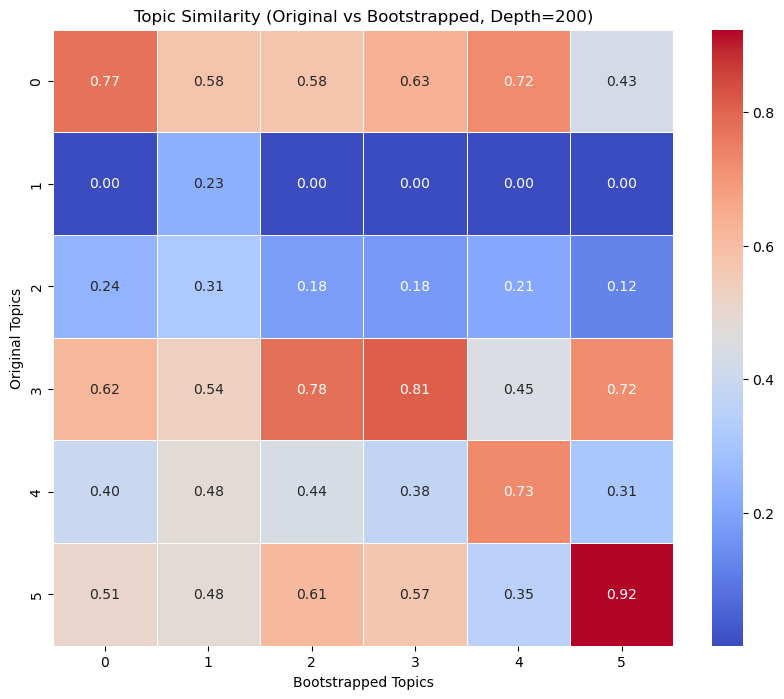

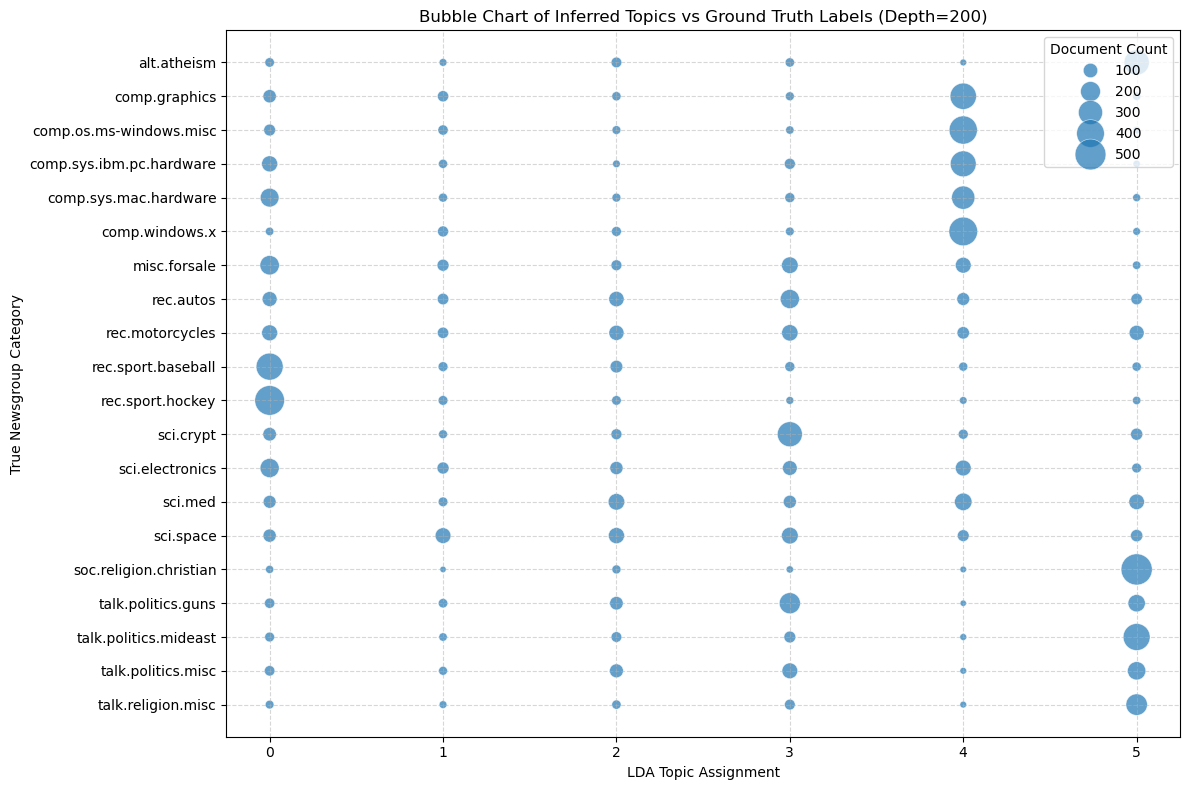


 Running LDA at sampling depth 500...

 Top words per topic (Depth=500):
Topic 0: edu does games team just year like think new game
Topic 1: hello work problems read just does like use ax space
Topic 2: people think know time ve use like good don just
Topic 3: don com car drive government test like think people just
Topic 4: need hi don problem use like windows does know thanks
Topic 5: believe time just like know think say don god people


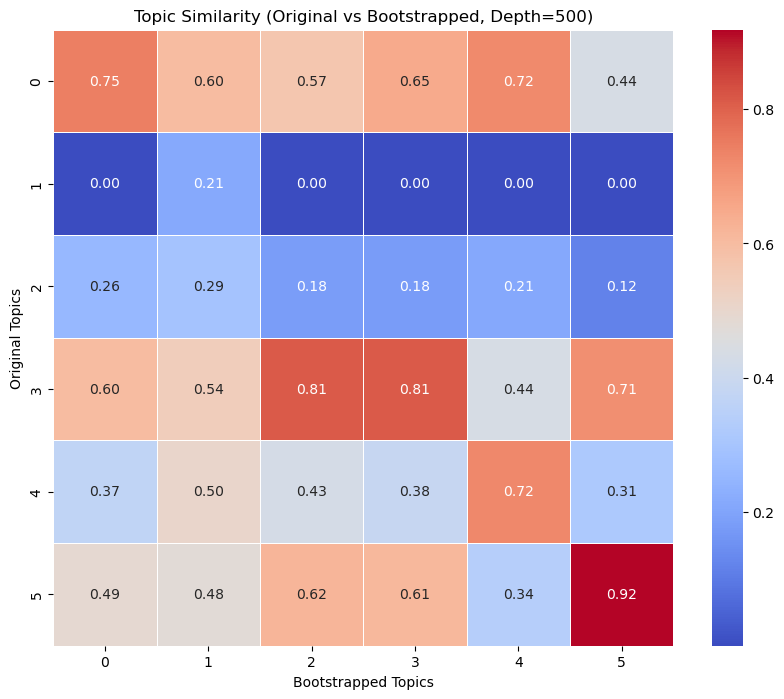

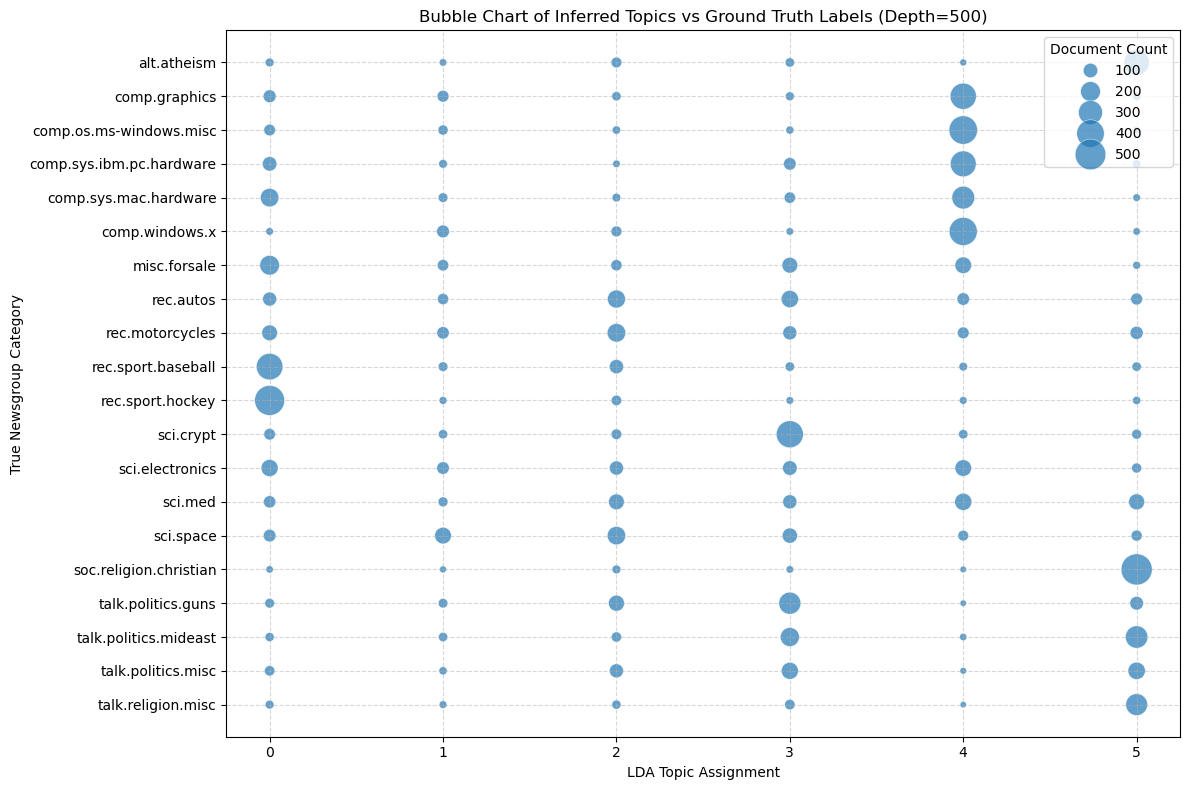

In [23]:
# run LDA on each depth
sampling_depths = [50, 100, 200, 500]
num_topics = 6

for depth in sampling_depths:
    print(f"\n Running LDA at sampling depth {depth}...")

    # resample and revectorize
    resampled_docs, resampled_labels = resample_documents(word_counts, depth=depth, return_labels=True)
    resampled_counts = vectorizer.transform(resampled_docs)

    # run LDA on bootstrapped data
    lda_bootstrap = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_bootstrap.fit(resampled_counts)
    bootstrap_topic_distributions = lda_bootstrap.components_ / lda_bootstrap.components_.sum(axis=1, keepdims=True)

    # top words per topic
    print(f"\n Top words per topic (Depth={depth}):")
    for topic_idx, topic in enumerate(lda_bootstrap.components_):
        top_words = [vocab[i] for i in topic.argsort()[-10:]]
        print(f"Topic {topic_idx}: {' '.join(top_words)}")

    # compute cosine similarity between topics
    similarity_matrix = cosine_similarity(original_topic_distributions, bootstrap_topic_distributions)

    # plot heat map chart
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
    )

    plt.title(f"Topic Similarity (Original vs Bootstrapped, Depth={depth})")
    plt.xlabel("Bootstrapped Topics")
    plt.ylabel("Original Topics")
    plt.show()

    doc_topic_probs = lda_bootstrap.transform(resampled_counts)
    topic_assignments = doc_topic_probs.argmax(axis=1)

    df = pd.DataFrame({
        'TrueLabel': resampled_labels,
        'Topic': topic_assignments
    })

    # group by label-topic pair and count
    grouped = df.groupby(['TrueLabel', 'Topic']).size().reset_index(name='Count')

    # map numeric labels to category names
    grouped['TrueLabelName'] = grouped['TrueLabel'].map(lambda i: newsgroups.target_names[i])

    # plot bubble chart
    plt.figure(figsize=(12, 8))
    bubble_plot = sns.scatterplot(
        data=grouped,
        x='Topic',
        y='TrueLabelName',
        size='Count',
        legend='brief',
        sizes=(20, 500),
        alpha=0.7
    )

    plt.title(f"Bubble Chart of Inferred Topics vs Ground Truth Labels (Depth={depth})")
    plt.xlabel("LDA Topic Assignment")
    plt.ylabel("True Newsgroup Category")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.legend(loc='upper right', title='Document Count')
    plt.show()

Try training on JUST the training set vs ground truth - see how boostrapping affects actual classification
Similar to body sites, compare how no bootstrapping maps to ground truth vs each sampling depth


--- Run 0: Random Resampling and LDA ---

Top words per topic (Run 0):
Topic 0: new year time know does don game like just think
Topic 1: thought hello use just space try does like ax people
Topic 2: make did know use think like people good don just
Topic 3: like test car drive new key probably think use just
Topic 4: hi mail program don like just does windows know thanks
Topic 5: said think true don know time drive like people god


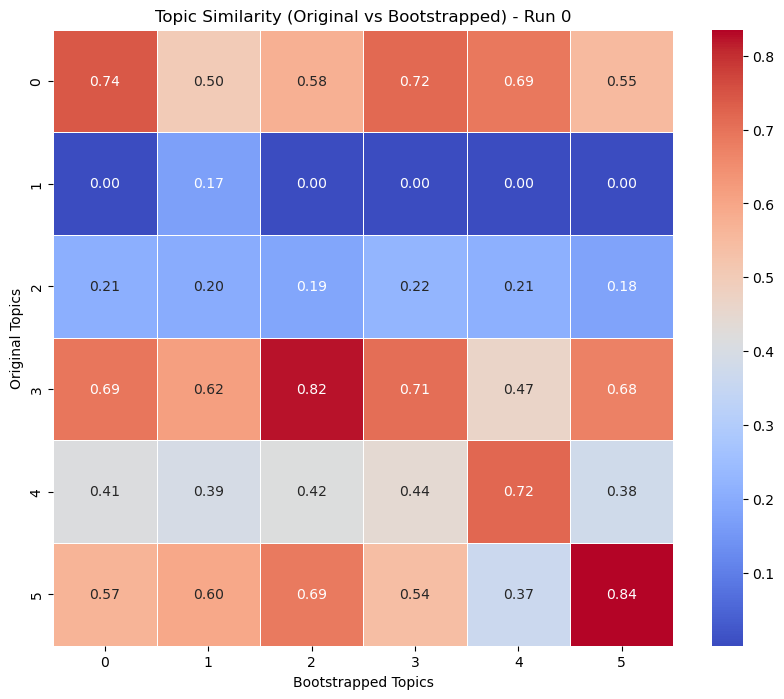

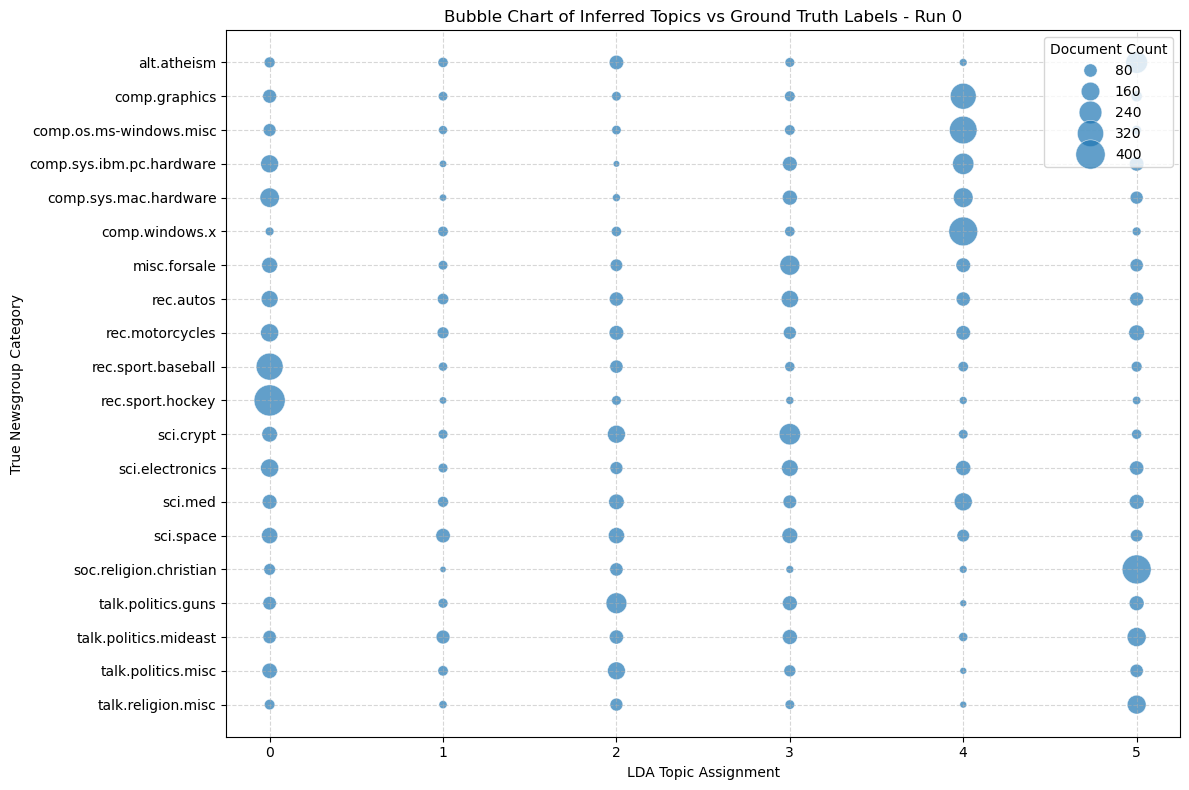


--- Run 1: Random Resampling and LDA ---

Top words per topic (Run 1):
Topic 0: did team does know don like game just think new
Topic 1: like space hello file ax does model problems use people
Topic 2: did ve time people think use like don just good
Topic 3: going new com right agree just like people think drive
Topic 4: need use hi just like does don windows know thanks
Topic 5: stuff time need deleted don know like people say god


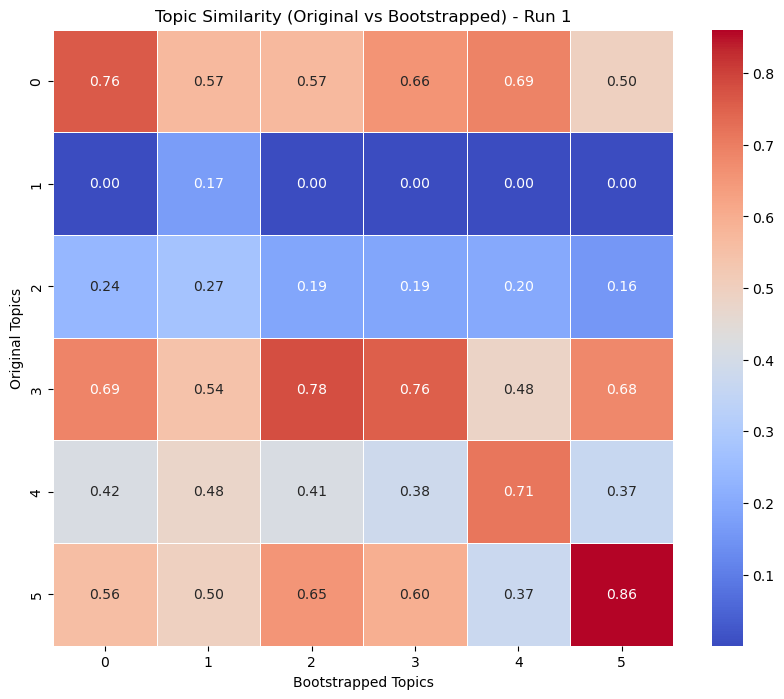

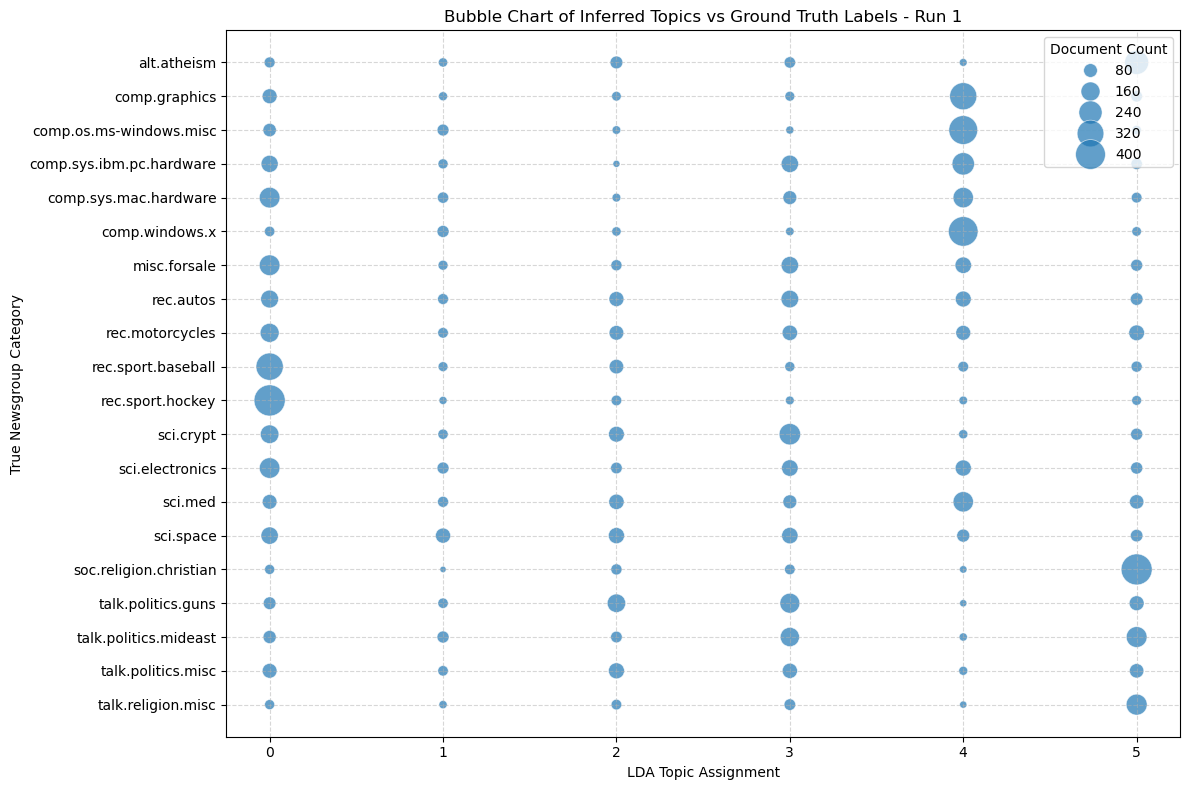


--- Run 2: Random Resampling and LDA ---

Top words per topic (Run 2):
Topic 0: team don edu know just new game think like does
Topic 1: deletion life model just hello like space use people ax
Topic 2: does think know time use like don ve just good
Topic 3: people car like use new com think scsi test drive
Topic 4: hi use problem just does like don windows know thanks
Topic 5: right just said know think don like say god people


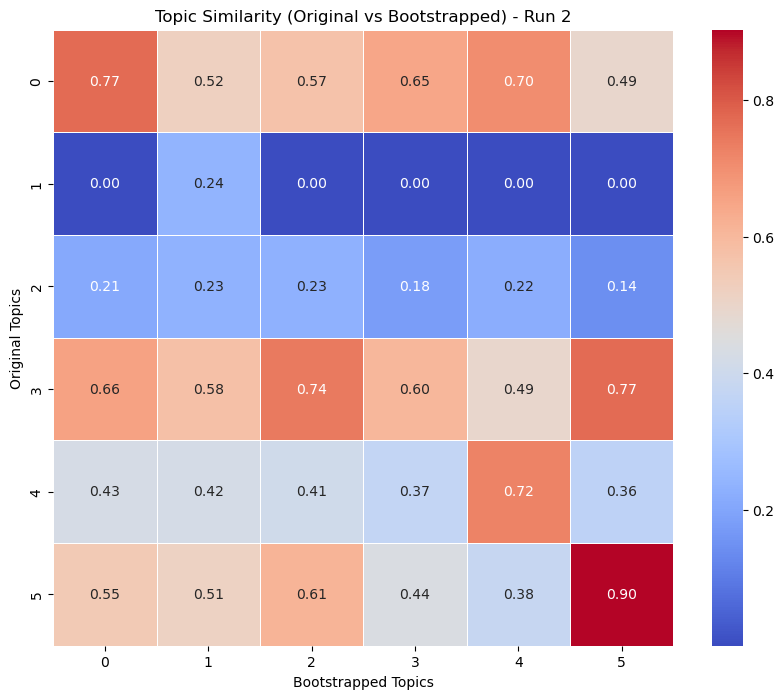

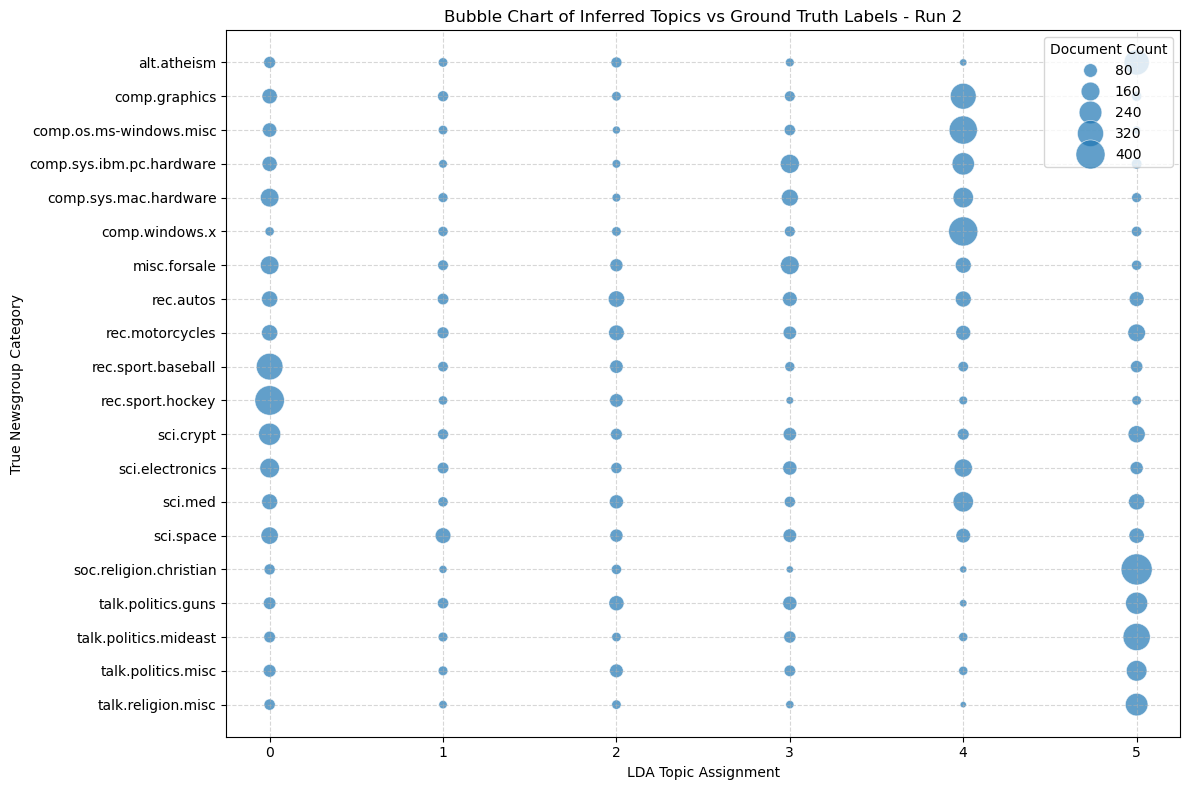

In [24]:
num_topics = 6
num_runs = 3

for run in range(0, num_runs):
    print(f"\n--- Run {run}: Random Resampling and LDA ---")

    # randomly resample documents
    resampled_docs, resampled_labels = resample_documents_random_depth(word_counts, return_labels=True)
    resampled_counts = vectorizer.transform(resampled_docs)

    # run LDA
    lda_bootstrap = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_bootstrap.fit(resampled_counts)
    bootstrap_topic_distributions = lda_bootstrap.components_ / lda_bootstrap.components_.sum(axis=1, keepdims=True)

    # top words
    print(f"\nTop words per topic (Run {run}):")
    for topic_idx, topic in enumerate(lda_bootstrap.components_):
        top_words = [vocab[i] for i in topic.argsort()[-10:]]
        print(f"Topic {topic_idx}: {' '.join(top_words)}")

    # cosine similarity
    similarity_matrix = cosine_similarity(original_topic_distributions, bootstrap_topic_distributions)

    # plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
    )
    plt.title(f"Topic Similarity (Original vs Bootstrapped) - Run {run}")
    plt.xlabel("Bootstrapped Topics")
    plt.ylabel("Original Topics")
    plt.show()

    # assign each document
    doc_topic_probs = lda_bootstrap.transform(resampled_counts)
    topic_assignments = doc_topic_probs.argmax(axis=1)

    df = pd.DataFrame({
        'TrueLabel': resampled_labels,
        'Topic': topic_assignments
    })

    # group by label-topic pair and count
    grouped = df.groupby(['TrueLabel', 'Topic']).size().reset_index(name='Count')
    grouped['TrueLabelName'] = grouped['TrueLabel'].map(lambda i: newsgroups.target_names[i])

    # plot bubble chart
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=grouped,
        x='Topic',
        y='TrueLabelName',
        size='Count',
        sizes=(20, 500),
        legend='brief',
        alpha=0.7
    )

    plt.title(f"Bubble Chart of Inferred Topics vs Ground Truth Labels - Run {run}")
    plt.xlabel("LDA Topic Assignment")
    plt.ylabel("True Newsgroup Category")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.legend(loc='upper right', title='Document Count')
    plt.show()